<a href="https://colab.research.google.com/github/manelbenabid/Lebanese-Arabizi-Tweet-Sentiment-Analysis/blob/main/Sentiment%20Analysis-%20Logistic%20Regression%20and%20GradientBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install jupyterthemes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 62.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 81.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 6.8 MB/s eta 0:00:00


In [2]:
!pip install clean-text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.4/175.4 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 5.2 MB/s eta 0:00:00
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171033 sha256=24da17d8309b2be5824a2e9adf4d965a0e96f7f28502c03bf1c16e287a391b28
  Stored in directory: /root/.cache/pip/wheels/31/8a/8c/315c9e5d7773f74b33d5ed33f075b49c6eaeb7cedbb86e2cf8
Successfully built emoji


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

In [4]:
df = pd.read_csv("https://raw.githubusercontent.com/manelbenabid/Lebanese-Arabizi-Tweet-Sentiment-Analysis/main/data/arabizi_tweets.csv")

In [5]:
df.head(10)

,tweet,sentiment,highlight
0,Aw enn l ahla men hek hay li btelbesle crop to...,Negative,None
1,yu2brnee jamelo pepe happy_face_smiley tfeh sh...,Negative,None
2,Lea ktir pedophile happy_face_smiley,Negative,Bullying
3,Shu hal hmar hayda,Negative,Bullying
4,Fasharet 3a ra2btak w ra2bit m3almak w ra2bit ...,Negative,None
5,Hayda ensen marid,Negative,None
6,my uncle is lowkey aawne w ktir aabele natfo,Negative,None
7,Bassam bte7lam feyon lal syesye bel leil as a ...,Negative,Sarcasm
8,@Ritarouhana helo ktir. Eza badkoun tejo kelko...,Negative,Sarcasm
9,Hayda ma biya3ref ye2ra w yektob w bedo wazire...,Negative,None


In [6]:
# convert sentiment to binary class [0,1]
df['class'] = df['sentiment'].map({'Positive': 1, 'Negative': 0})

In [7]:
df.tail(5)

,tweet,sentiment,highlight,class
1173,@ClementHakim helo el tafe2ol happy_face_smile...,Positive,None,1
1174,lah helo short hair,Positive,Courtesy words,1
1175,ya allah enta w batnak hahahaha,Positive,Joke,1
1176,-malla a7lam ya zalame -eh man sa2ile ktir - l...,Positive,Joke,1
1177,W yimkin chi nhar u3a mn l nom la2i hadi bel f...,Positive,Joke,1


array([[<Axes: title={'center': 'class'}>]], dtype=object)

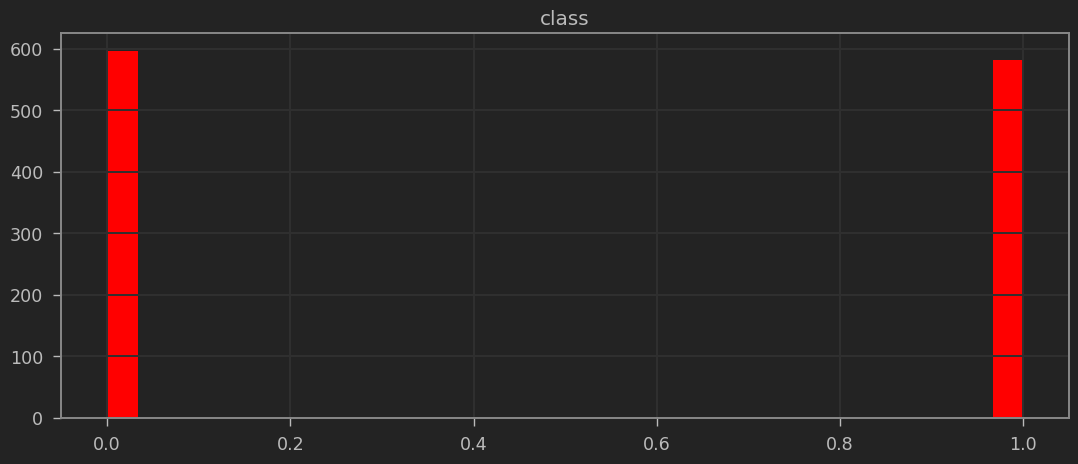

In [8]:
# Plot the histogram
df.hist(bins=30, figsize=(13,5), color='red')

In [9]:
df.sentiment.value_counts()

Negative    596
Positive    582
Name: sentiment, dtype: int64

<Axes: xlabel='class', ylabel='count'>

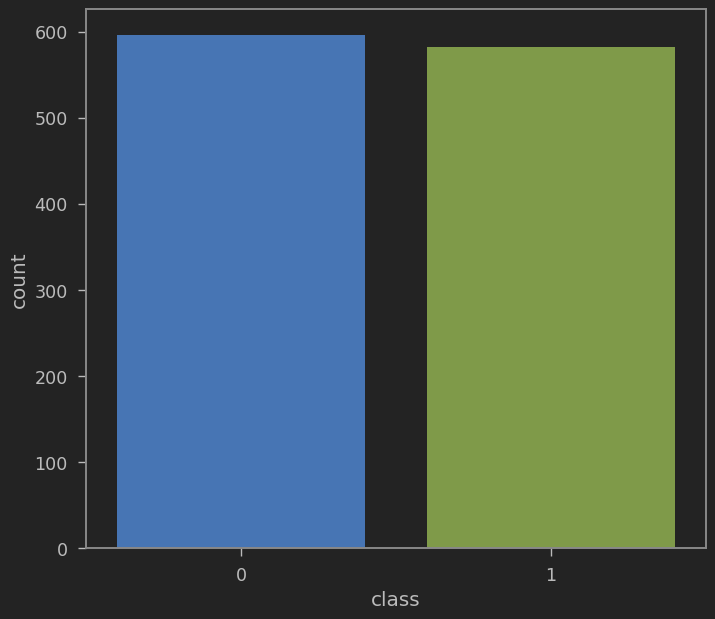

In [10]:
sns.countplot(df, x="class")

In [11]:
# Let's get the length of the messages
df['length'] = df['tweet'].apply(len)
df.head(10)

,tweet,sentiment,highlight,class,length
0,Aw enn l ahla men hek hay li btelbesle crop to...,Negative,None,0,135
1,yu2brnee jamelo pepe happy_face_smiley tfeh sh...,Negative,None,0,89
2,Lea ktir pedophile happy_face_smiley,Negative,Bullying,0,36
3,Shu hal hmar hayda,Negative,Bullying,0,18
4,Fasharet 3a ra2btak w ra2bit m3almak w ra2bit ...,Negative,None,0,58
5,Hayda ensen marid,Negative,None,0,17
6,my uncle is lowkey aawne w ktir aabele natfo,Negative,None,0,44
7,Bassam bte7lam feyon lal syesye bel leil as a ...,Negative,Sarcasm,0,74
8,@Ritarouhana helo ktir. Eza badkoun tejo kelko...,Negative,Sarcasm,0,154
9,Hayda ma biya3ref ye2ra w yektob w bedo wazire...,Negative,None,0,85


In [12]:
df.describe()

,class,length
count,1178.000000,1178.000000
mean,0.494058,68.928693
std,0.500177,47.071377
min,0.000000,4.000000
25%,0.000000,36.000000
50%,0.000000,60.000000
75%,1.000000,90.000000
max,1.000000,620.000000


In [13]:
# Let's view the shortest tweet
df[df['length'] == 4]['tweet']

1127    Atel
Name: tweet, dtype: object

# Data Preprocessing

1. convert to lower-case
1. remove punctuation, mentions, URLs, numbers, measurements, and timings
1. remove stop words

In [14]:
import re

def remove_tags_hashtags_url(tweet):
    # Remove hashtags (words starting with #)
    tweet = re.sub(r'#\w+', '', tweet)

    # Remove mentions (words starting with @)
    tweet = re.sub(r'@\w+', '', tweet)

    # Remove URLs (using a regular expression to match common URL patterns)
    tweet = re.sub(r'http[s]?://\S+', '', tweet)

    # Remove extra spaces and trim the tweet
    tweet = ' '.join(tweet.split())

    return tweet

In [15]:
tweet = df['tweet'][266]
print(tweet)
clean_tweet = remove_tags_hashtags_url(tweet)
print(clean_tweet)

Hahahhahaha albo melyen menna ðŸ¤£ https://www.facebook.com/723616625/posts/10156414568561626/
Hahahhahaha albo melyen menna ðŸ¤£


In [16]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [17]:
import nltk # Natural Language tool kit
nltk.download('stopwords')

# You have to download stopwords Package to execute this command
from nltk.corpus import stopwords
stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [18]:
stopwords.words('french')

['au',
 'aux',
 'avec',
 'ce',
 'ces',
 'dans',
 'de',
 'des',
 'du',
 'elle',
 'en',
 'et',
 'eux',
 'il',
 'ils',
 'je',
 'la',
 'le',
 'les',
 'leur',
 'lui',
 'ma',
 'mais',
 'me',
 'même',
 'mes',
 'moi',
 'mon',
 'ne',
 'nos',
 'notre',
 'nous',
 'on',
 'ou',
 'par',
 'pas',
 'pour',
 'qu',
 'que',
 'qui',
 'sa',
 'se',
 'ses',
 'son',
 'sur',
 'ta',
 'te',
 'tes',
 'toi',
 'ton',
 'tu',
 'un',
 'une',
 'vos',
 'votre',
 'vous',
 'c',
 'd',
 'j',
 'l',
 'à',
 'm',
 'n',
 's',
 't',
 'y',
 'été',
 'étée',
 'étées',
 'étés',
 'étant',
 'étante',
 'étants',
 'étantes',
 'suis',
 'es',
 'est',
 'sommes',
 'êtes',
 'sont',
 'serai',
 'seras',
 'sera',
 'serons',
 'serez',
 'seront',
 'serais',
 'serait',
 'serions',
 'seriez',
 'seraient',
 'étais',
 'était',
 'étions',
 'étiez',
 'étaient',
 'fus',
 'fut',
 'fûmes',
 'fûtes',
 'furent',
 'sois',
 'soit',
 'soyons',
 'soyez',
 'soient',
 'fusse',
 'fusses',
 'fût',
 'fussions',
 'fussiez',
 'fussent',
 'ayant',
 'ayante',
 'ayantes',


In [19]:
arabizi_stopwords = ['chu', 'chou', 'shu', 'shou', 'hal', 'fikeee', 'fike', 'eh', 'ma', '3a', '3am', '3an', '3ana', '3endon', '3m', 'aal', '3al','3ala','al', 'ana',
                 'b', 'bas', 'bass', 'bel', 'bi', 'chi', 'el', 'ele', 'enn', 'enno', 'eno', 'mch', 'mech', 'mish', '3layki', '3layon',
                 'enta', 'enteh','ente', 'eza', 'fi', 'fik', 'fina', 'fine', 'fiya', 'fiye', 'wlik', 'shi',
                 'hal', 'hayda', 'hek', 'inta', 'iza', 'kaza', 'kel', 'kente', 'kif',
                 'kint', 'kinte', 'l',  'la2na', 'lal', 'li', 'ma3', 'ma3a', 'ma3ak',
                 'ma3e', 'ma3ekk', 'ma3i', 'ma3ik', 'ma3ke', 'ma3na', 'ma3o', 'men', 'mn',
                 'n7na', 'tab', 'tayeb', 'w', 'aw', 'wlek', 'ya', 'ya3ne', 'yaane', 'yalla', 'yala', 'yalle',
                     'bl', 'hayde', 'leh', 'hay', 'lech', 'lesh']

In [20]:
def remove_punction_stop_words(tweet):
    Test_punc_removed = [char for char in tweet if char not in string.punctuation]
    Test_punc_removed_join = ''.join(Test_punc_removed)
    Test_punc_removed_join_clean_eng = [word for word in Test_punc_removed_join.split() if word.lower() not in stopwords.words('english')]
    Test_punc_removed_join_eng = ' '.join(Test_punc_removed_join_clean_eng)
    Test_punc_removed_join_clean_fr = [word for word in Test_punc_removed_join_eng.split() if word.lower() not in stopwords.words('french')]
    Test_punc_removed_join_fr = ' '.join(Test_punc_removed_join_clean_fr)
    Test_punc_removed_join_clean = [word for word in Test_punc_removed_join_fr.split() if word.lower() not in arabizi_stopwords]
    return ' '.join(Test_punc_removed_join_clean)

In [21]:
df['tweet'][0]

'Aw enn l ahla men hek hay li btelbesle crop top b noss din l sa23a w l talej w bte23ad tne2 "Msa23a" "Ya alla ktir sa23a" N2ebre lbese.'

In [22]:
clean_tweet = remove_punction_stop_words(df['tweet'][0])
clean_tweet

'ahla btelbesle crop top noss din sa23a talej bte23ad tne2 Msa23a alla ktir sa23a N2ebre lbese'

In [23]:
# function that converts tweets to lowercase
def convert_to_lowercase(tweet):
    return tweet.lower()

In [24]:
# Example usage:
text = "Shu hal HMAR hayda"
lowercase_text = convert_to_lowercase(text)

print(lowercase_text)

shu hal hmar hayda


In [25]:
def sound_effects(tweet):
    # substitute laughter sound effect
    tweet = re.sub(r'\b(hahah*)+\b', 'laughter', tweet)
    tweet = re.sub(r'\b(hihih*)+\b', 'laughter', tweet)
    tweet = re.sub(r'\b(heheh*)+\b', 'laughter', tweet)
    tweet = re.sub(r'\bwaha(ha)+\b', 'laughter', tweet)
    tweet = re.sub(r'\b(lo+l*)+\b', 'laughter', tweet)

    # substitute amazement
    tweet = re.sub(r'\b(y+a+)+y+\b', 'amazement', tweet)
    tweet = re.sub(r'\b(w+o+)+w+\b', 'amazement', tweet)
    tweet = re.sub(r'\b(w+a+)+w+\b', 'amazement', tweet)
    tweet = re.sub(r'\b(w+o+a+h+)\b', 'amazement', tweet)

    # substitute surprise
    tweet = re.sub(r'\bo+h+\b', 'surprise', tweet)
    tweet = re.sub(r'\ba+h+\b', 'surprise', tweet)
    tweet = re.sub(r'\bo+w+\b', 'surprise', tweet)


    # Remove extra spaces and trim the tweet
    tweet = ' '.join(tweet.split())

    return tweet

In [26]:
tweet = ''' hahahhahah shou mahdoum looololol
yyayyyy waawww wow oooohhhh aaahhhhh owwww woaaahhh'''
tweet = sound_effects(tweet)
print(tweet)

laughter shou mahdoum laughter amazement amazement amazement surprise surprise surprise amazement


In [27]:
# removing numbers
def remove_standalone_numbers(tweet):
    tweet =  re.sub(r'\b\d+\b', '', tweet)

    # Remove extra spaces and trim the tweet
    tweet = ' '.join(tweet.split())

    return tweet


In [28]:
# Example usage:
input_string = "Hello 123 World 456. Remove 789 and keep th1s and la2."
result = remove_standalone_numbers(input_string)
print(result)

Hello World . Remove and keep th1s and la2.


In [29]:
from cleantext import clean


def remove_emojis(tweet):
    return clean(tweet, no_emoji=True)

# Example usage:
tweet = "This is a tweet with emojis! 😊🚀🎉"
cleaned_tweet = remove_emojis(tweet)

print(cleaned_tweet)


this is a tweet with emojis!


# Data Cleaning

We will apply the functions that we created on the data we have in this order:
1. Remove user mentions, URLs, hashtags
1. Remove emojis
1. Remove standalone numbers
1. Remove punctuation and stop words
1. Convert to lowercase
1. Replace sound effects

*Note*: We have replaced all the important emojis before so in step 2. remove emojis we are removing non-significant emojis such as "eyes" and "fire" and others.

In [30]:
def tweet_cleaning(tweet):
  tweet = remove_tags_hashtags_url(tweet)
  tweet = remove_emojis(tweet)
  tweet = remove_standalone_numbers(tweet)
  tweet = remove_punction_stop_words(tweet)
  tweet = convert_to_lowercase(tweet)
  tweet = sound_effects(tweet)

  return tweet

In [31]:
tweet = df['tweet'][31]
print("Original tweet:\n" +tweet)
clean_tweet = tweet_cleaning(tweet)
print("Clean tweet:\n" + clean_tweet)

Original tweet:
Enno baddak ba3d 10 snin tenye!!!!??? Latgibo lkahraba??? Ya chabih lbani admin l3alam kello 3am bi2oul 3endkon hader belkahraba. Fachart ya harami wya 🐇🐇🐇🐇🐇
Clean tweet:
baddak ba3d snin tenye latgibo lkahraba chabih lbani admin l3alam kello bi2oul 3endkon hader belkahraba fachart harami wya


In [32]:
# Let's test the cleaning functions
df_clean = df
df_clean['tweet'] = df['tweet'].apply(tweet_cleaning)

In [33]:
df_clean

,tweet,sentiment,highlight,class,length
0,ahla btelbesle crop top noss din sa23a talej b...,Negative,None,0,135
1,yu2brnee jamelo pepe happyfacesmiley tfeh bech...,Negative,None,0,89
2,lea ktir pedophile happyfacesmiley,Negative,Bullying,0,36
3,hmar,Negative,Bullying,0,18
4,fasharet ra2btak ra2bit m3almak ra2bit khalafouk,Negative,None,0,58
...,...,...,...,...,...
1173,helo tafe2ol happyfacesmiley happyfacesmiley,Positive,None,1,65
1174,lah helo short hair,Positive,Courtesy words,1,19
1175,allah batnak laughter,Positive,Joke,1,31
1176,malla a7lam zalame man sa2ile ktir lah zake mb...,Positive,Joke,1,103


# Plot the word Cloud

In [34]:
positive = df_clean[df_clean['class']==1]
positive.head(10)

,tweet,sentiment,highlight,class,length
596,mwal3eta ween ken twitter insta happyfacesmiley,Positive,None,1,79
597,kazem saher ahla ahdam aklas 3alam,Positive,None,1,67
598,wayle helo goal,Positive,None,1,70
599,allah ayshek queen,Positive,None,1,21
600,bhbak,Positive,None,1,5
601,la2 helo ktir shab,Positive,None,1,39
602,hahaha tb howe ktr helo happyfacesmiley hahaha,Positive,None,1,71
603,kteer wjouh helwe twitter lyom allah yehmikon,Positive,None,1,51
604,wel3aani 3aylet happyfacesmiley lebanon,Positive,None,1,240
605,merci madame chta2nelik ktir happyfacesmiley,Positive,Courtesy words,1,74


In [35]:
negative = df_clean[df_clean['class']==0]
negative

,tweet,sentiment,highlight,class,length
0,ahla btelbesle crop top noss din sa23a talej b...,Negative,None,0,135
1,yu2brnee jamelo pepe happyfacesmiley tfeh bech...,Negative,None,0,89
2,lea ktir pedophile happyfacesmiley,Negative,Bullying,0,36
3,hmar,Negative,Bullying,0,18
4,fasharet ra2btak ra2bit m3almak ra2bit khalafouk,Negative,None,0,58
...,...,...,...,...,...
591,tlo3et booster mnih 3melet sakte albie,Negative,None,0,45
592,ktir sara333 wa2et ide albe,Negative,None,0,39
593,ok maybe ktir khaffe2 alile jarrabet semhoune,Negative,None,0,63
594,meto pupies frownsadangrypouting,Negative,None,0,42


In [36]:
sentences = df_clean['tweet'].tolist()
len(sentences)

1178

In [37]:
sentences_as_one_string =" ".join(sentences)

In [38]:
!pip install wordcloud

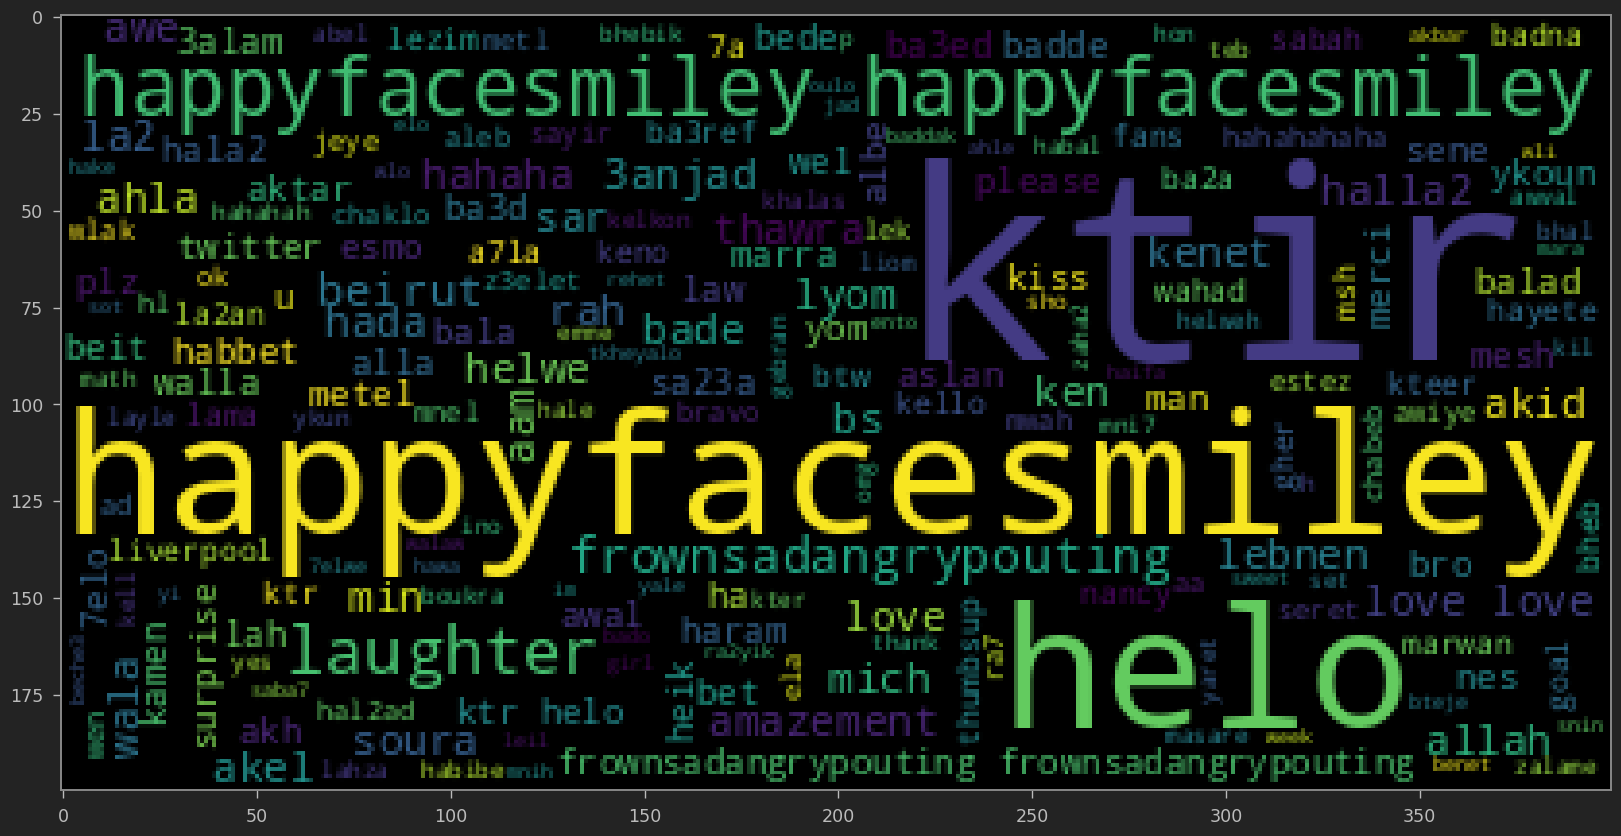

In [39]:
from wordcloud import WordCloud

plt.figure(figsize=(20,20))
plt.imshow(WordCloud().generate(sentences_as_one_string))

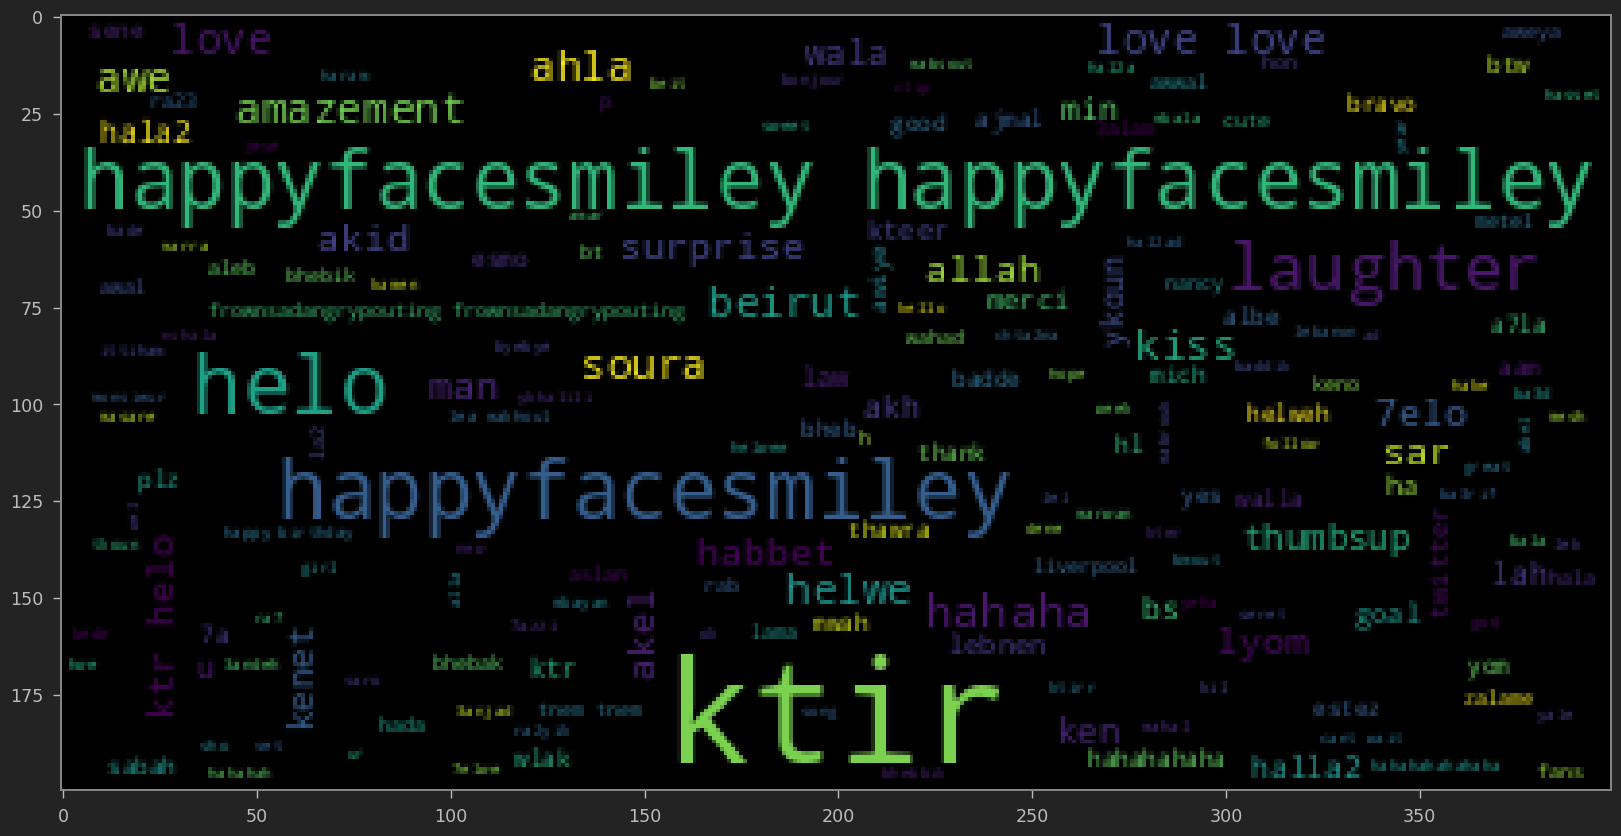

In [40]:
pos_sentences = positive['tweet'].tolist()
pos_sentences_as_one_string =" ".join(pos_sentences)
plt.figure(figsize=(20,20))
plt.imshow(WordCloud().generate(pos_sentences_as_one_string))

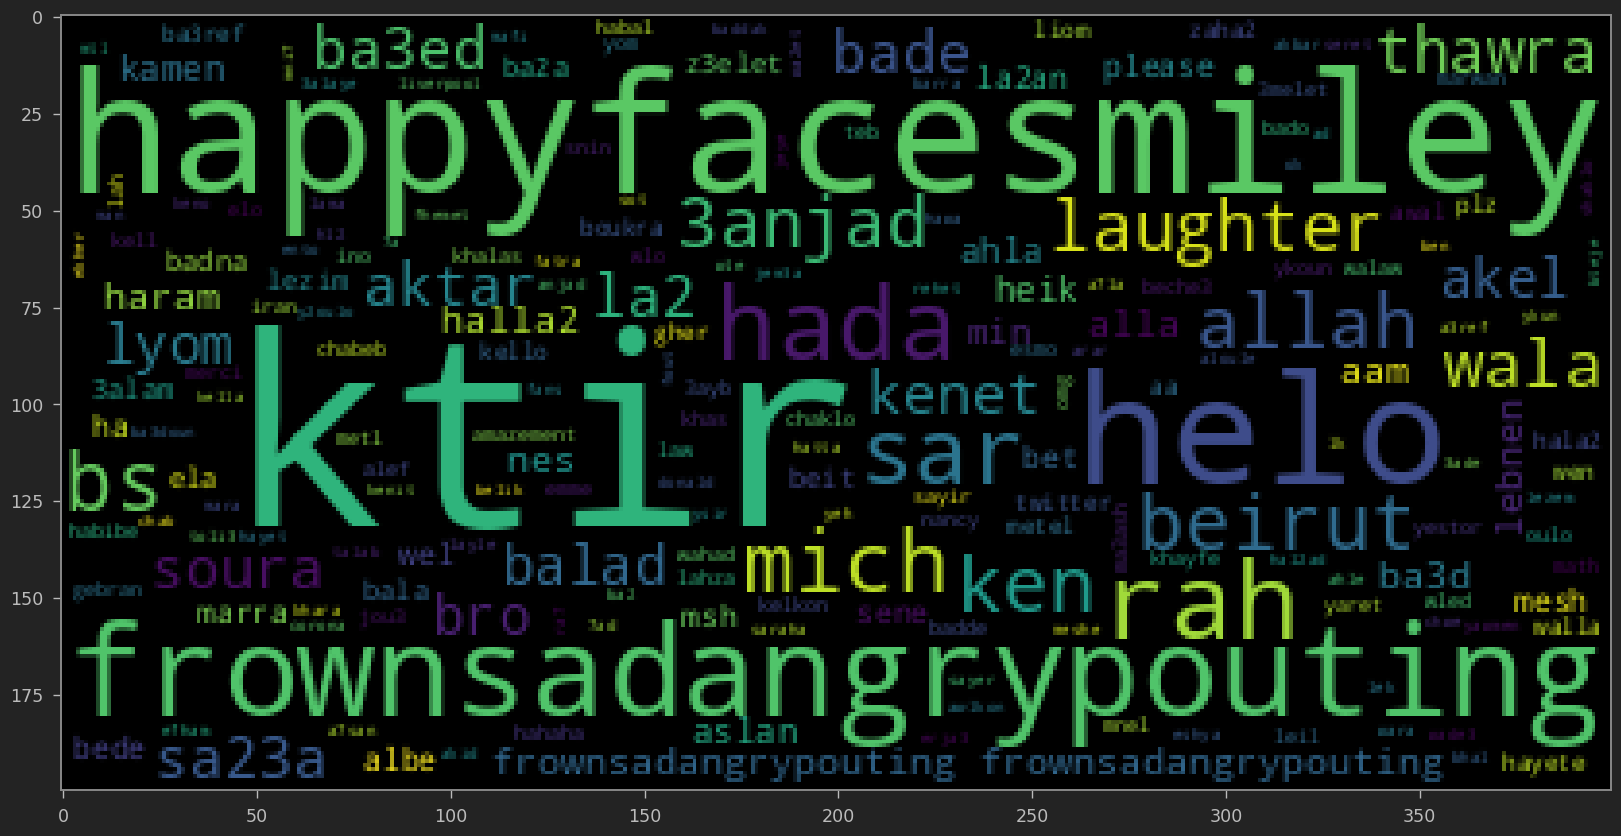

In [41]:
neg_sentences = negative['tweet'].tolist()
neg_sentences_as_one_string =" ".join(neg_sentences)
plt.figure(figsize=(20,20))
plt.imshow(WordCloud().generate(neg_sentences_as_one_string))

# Perform count vectorization

In [42]:
from sklearn.feature_extraction.text import CountVectorizer
# Define the cleaning pipeline we defined earlier
vectorizer = CountVectorizer(analyzer = tweet_cleaning, dtype = np.uint8) # the dtype is important
tweets_countvectorizer = vectorizer.fit_transform(df['tweet'])


In [43]:
print(tweets_countvectorizer.toarray())

[[15  0  0 ...  0  0  0]
 [ 9  0  0 ...  0  3  1]
 [ 3  0  0 ...  0  2  0]
 ...
 [ 2  0  0 ...  0  0  0]
 [13  0  0 ...  0  0  2]
 [ 6  0  0 ...  0  1  0]]


In [44]:
tweets_countvectorizer.shape

(1178, 37)

In [45]:
X = pd.DataFrame(tweets_countvectorizer.toarray())
X

,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,35,36
0,15,0,0,6,4,0,0,0,0,0,...,0,3,7,6,0,0,0,0,0,0
1,9,0,0,1,1,0,0,0,1,0,...,0,2,1,2,1,0,0,0,3,1
2,3,0,0,0,0,0,0,0,0,0,...,0,1,1,1,0,0,0,0,2,0
3,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,5,0,0,3,1,0,0,0,0,0,...,0,4,1,4,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1173,3,0,0,1,0,0,0,0,0,0,...,0,0,2,1,0,0,0,0,4,0
1174,3,0,0,0,0,0,0,0,0,0,...,0,2,1,1,0,0,0,0,0,0
1175,2,0,0,0,0,0,0,0,0,0,...,0,1,0,2,1,0,0,0,0,0
1176,13,0,0,1,0,0,0,0,3,0,...,0,3,2,4,0,0,0,0,0,2


In [46]:
y = df['class']

In [47]:
X.shape

(1178, 37)

In [48]:
y.shape

(1178,)

In [64]:
# split the data into 80-20 train-test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Train and evaluate a Naive Bayes classifier model

In [ ]:
from sklearn.naive_bayes import MultinomialNB
NB_classifier = MultinomialNB()
NB_classifier.fit(X_train, y_train)

MultinomialNB()

Making predictions

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score

<Axes: >

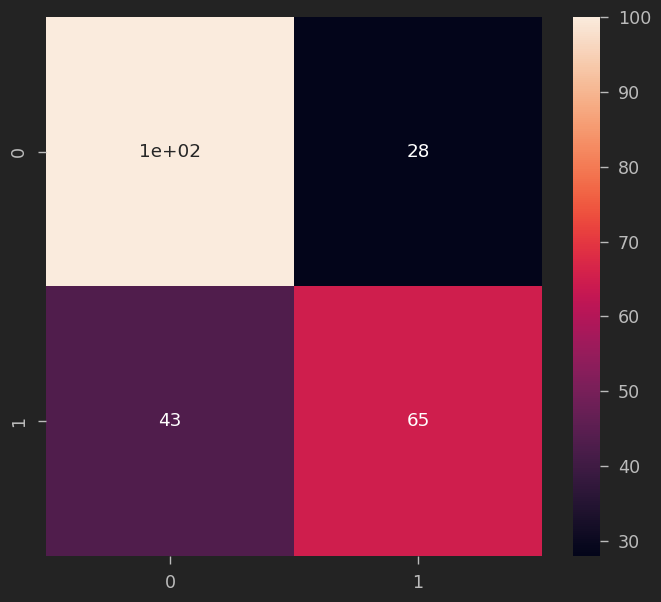

In [ ]:
# Predicting the Test set results
y_predict_test = NB_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_predict_test)
cm = confusion_matrix(y_test, y_predict_test)
sns.heatmap(cm, annot=True)

In [ ]:
print(f'Accuracy: {accuracy}')
print(classification_report(y_test, y_predict_test))

Accuracy: 0.6991525423728814
              precision    recall  f1-score   support

           0       0.70      0.78      0.74       128
           1       0.70      0.60      0.65       108

    accuracy                           0.70       236
   macro avg       0.70      0.69      0.69       236
weighted avg       0.70      0.70      0.70       236



# Train and evaluate Logistic Regression Model

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           0       0.76      0.70      0.73       128
           1       0.67      0.74      0.70       108

    accuracy                           0.72       236
   macro avg       0.72      0.72      0.72       236
weighted avg       0.72      0.72      0.72       236



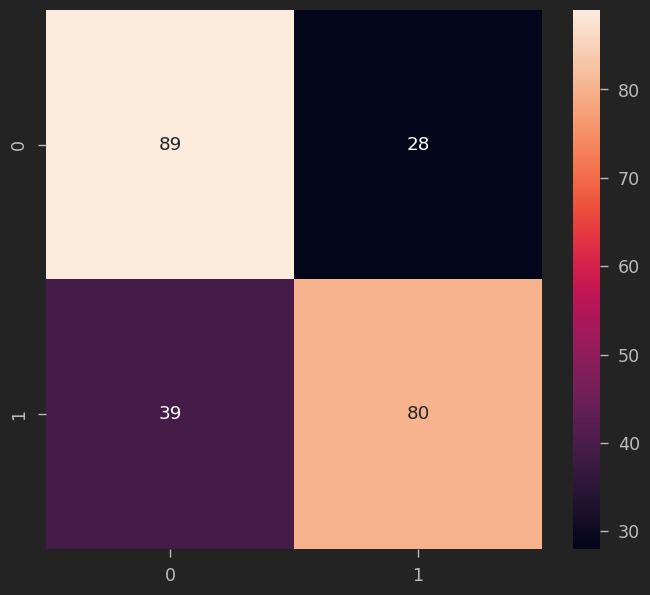

In [ ]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
# train the model
model.fit(X_train, y_train)

# make predictions
y_pred = model.predict(X_test)

cm = confusion_matrix(y_pred, y_test)
sns.heatmap(cm, annot = True)

print(classification_report(y_test, y_pred))

Performing hyperparameter tuning using GridSearchCV

In [ ]:
from sklearn.model_selection import GridSearchCV

model = LogisticRegression()

param_grid = [
    {'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
    'max_iter' : [10, 100]
    }
]

clf = GridSearchCV(model, param_grid = param_grid, cv = 10,
                   verbose=False, n_jobs=-1)

# train the classifier
clf.fit(X_train, y_train)

# get the best model
best_model = clf.best_estimator_


Accuracy = 0.7161016949152542
              precision    recall  f1-score   support

           0       0.76      0.70      0.73       128
           1       0.67      0.74      0.70       108

    accuracy                           0.72       236
   macro avg       0.72      0.72      0.72       236
weighted avg       0.72      0.72      0.72       236



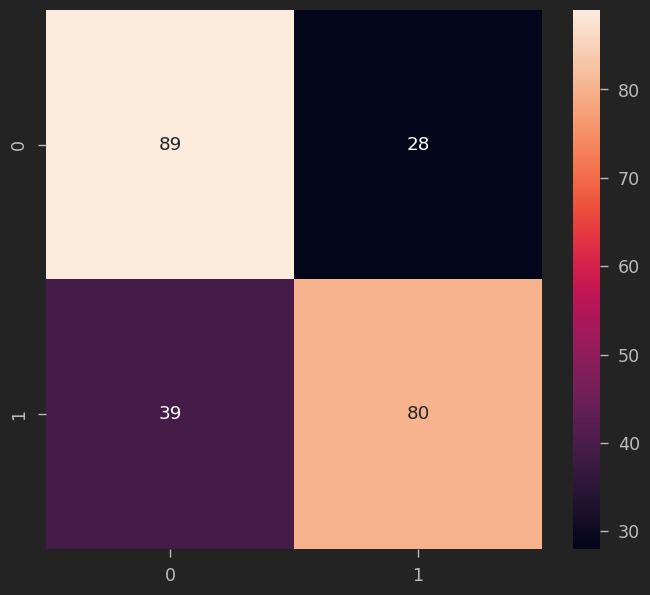

In [ ]:
# make predictions
y_pred = best_model.predict(X_test)


print(f'Accuracy = {accuracy}')
cm = confusion_matrix(y_pred, y_test)
sns.heatmap(cm, annot = True)

print(classification_report(y_test, y_pred))

# Train and test a Gradient Boosting Classifier

              precision    recall  f1-score   support

           0       0.79      0.72      0.75       128
           1       0.70      0.78      0.74       108

    accuracy                           0.75       236
   macro avg       0.75      0.75      0.75       236
weighted avg       0.75      0.75      0.75       236



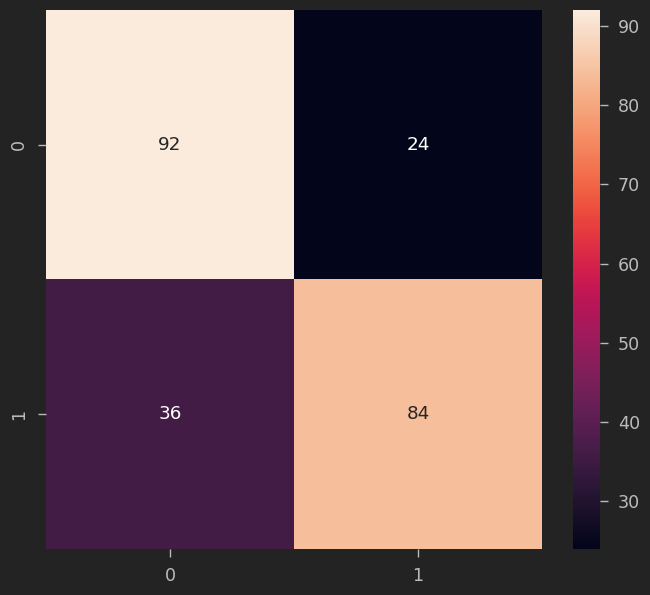

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_pred, y_test)
sns.heatmap(cm, annot = True)

print(classification_report(y_test, y_pred))

## Train and evaluate a Random Forest Classifier with Hyperparameter Tuning

In [62]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [65]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state = 42)
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation,
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [66]:
rf_random.best_params_

{'n_estimators': 800,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 90,
 'bootstrap': True}

We compare the base model with the best model obtained by randomizedSearch

In [67]:
from sklearn.metrics import accuracy_score
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    accuracy = accuracy_score(test_labels, predictions)
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))

    return accuracy
base_model = RandomForestClassifier(n_estimators = 10, random_state = 42)
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_test, y_test)

Model Performance
Average Error: 0.2966 degrees.
Accuracy = 0.70%.


In [68]:
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test)

Model Performance
Average Error: 0.2458 degrees.
Accuracy = 0.75%.


In [69]:
print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Improvement of 7.23%.


## Train and evaluate Decision Tree Model with Hyperparameter Tuning

In [70]:
from sklearn.tree import DecisionTreeClassifier

base_model = DecisionTreeClassifier()
base_model.fit(X_train, y_train)

DecisionTreeClassifier()

In [72]:
base_model.predict(X_test)
base_accuracy = evaluate(base_model, X_test, y_test)

Model Performance
Average Error: 0.4280 degrees.
Accuracy = 0.57%.


In [86]:
param_dict = {
    "criterion": ['gini', 'entropy'],
    "max_depth": range(1,10),
    "min_samples_split": range(1,10),
    "min_samples_leaf": range(1,5)
}

In [ ]:
from sklearn.model_selection import GridSearchCV
dt = DecisionTreeClassifier()
grid = GridSearchCV(dt,
                    param_grid = param_dict,
                    cv = 10,
                    verbose = 1, n_jobs = -1)
grid.fit(X_train, y_train)

In [88]:
grid.best_params_

{'criterion': 'gini',
 'max_depth': 5,
 'min_samples_leaf': 3,
 'min_samples_split': 8}

In [89]:
best_model = grid.best_estimator_
test_accuracy = evaluate(best_model, X_test, y_test)

Model Performance
Average Error: 0.3390 degrees.
Accuracy = 0.66%.


In [90]:
print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Improvement of 31.85%.


## Train and evaluate SVM model with hyperparameter tuning

In [93]:
from sklearn.svm import SVC
poly = SVC(kernel="poly", degree = 2)
poly.fit(X_train, y_train)

# print prediction results
acc_poly = evaluate(poly, X_test, y_test)

Model Performance
Average Error: 0.3178 degrees.
Accuracy = 0.68%.


In [94]:
linear = SVC(kernel = "linear")
linear.fit(X_train, y_train)

# print prediction results
acc_linear = evaluate(linear, X_test, y_test)

Model Performance
Average Error: 0.2966 degrees.
Accuracy = 0.70%.


In [95]:
sigmoid = SVC(kernel = "sigmoid")
sigmoid.fit(X_train, y_train)

# print prediction results
acc_sigmoid = evaluate(sigmoid, X_test, y_test)

Model Performance
Average Error: 0.5042 degrees.
Accuracy = 0.50%.


In [96]:
rbf = SVC(kernel="rbf")
rbf.fit(X_train, y_train)

# print prediction results
acc_rbf = evaluate(rbf, X_test, y_test)

Model Performance
Average Error: 0.3051 degrees.
Accuracy = 0.69%.


In [97]:
# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100],
              'gamma': ['scale', 'auto', 0.1, 1, 10],
              'kernel': ['rbf', 'linear', 'poly', 'sigmoid']}

grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 0)

# fitting the model for grid search
grid.fit(X_train, y_train)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100],
                         'gamma': ['scale', 'auto', 0.1, 1, 10],
                         'kernel': ['rbf', 'linear', 'poly', 'sigmoid']})

In [98]:
# print best parameter after tuning
print(grid.best_params_)

# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

{'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
SVC(C=1, kernel='linear')


In [99]:
best_model = grid.best_estimator_
test_accuracy = evaluate(best_model, X_test, y_test)

Model Performance
Average Error: 0.2966 degrees.
Accuracy = 0.70%.
